#Introduction

This report investigates the relationship between student–teacher ratios and student academic performance across 20 U.S. states. The goal is to understand whether states with smaller class sizes (lower student–teacher ratios) tend to perform better on standardized tests such as the ACT. This question matters for education policymakers and administrators who must allocate resources efficiently while improving student learning outcomes. By analyzing publicly available datasets, the project explores whether smaller classes correlate with stronger academic results.

In addition to this, I will examine the relationship between the average ACT score and the five socioeconomic predictor variables in the EdGap data set to check which socioeconomic predictor variable has closer relationship or effect on a student’s performance in the 20 states we have data from.


# Description of the source of the data

The school information data is from the National Center for Education Statistics. This data set consists of basic identifying information about schools and can be assumed to be of reasonably high quality. As for the EdGap.org data, the school information data is public, so we would be able to consult the original data sources to check the quality of the data if we had any questions.

The data set EdGap_data.xlsx can be accessed from the Github repository for DATA 5100

The data set ccd_sch_029_1617_w_1a_11212017.csv is too large for Github and can be accessed from the dropbox link:

https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=1

The data set Student Teacher Ratio is from below link:

NCES (National Center for Education Statistics)-
https://nces.ed.gov/ccd/elsi/tableGenerator.aspx?savedTableID=651538

# Setting Up the Environment

## Import Libraries

In [2]:
#Import pandas, numpy and matplotlib
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt

#Seaborn is a data visualization library built on matplotlib
import seaborn as sns

#Set the plotting style
sns.set_style("whitegrid")

#Model Processing
from sklearn.preprocessing import StandardScaler

#Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Model metrics and analysis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.anova import anova_lm

!pip install xlrd

We are loading data from a URL, explore it, visualize relationships, prepare and standardize features, build an OLS regression model, test significance with ANOVA, and evaluate performance with MSE and R².

In [3]:
url = "https://raw.githubusercontent.com/Kaurgurpreet23/Education/main/data/EdGap_data.xlsx"
response = requests.get(url)
edgap = pd.read_excel(io.BytesIO(response.content), dtype={'NCESSCH School ID': object})

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Handling File Downloads and Special Options

### Download the school information set

In [4]:
!wget ccd_sch_029_1617_w_1a_11212017 https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0

--2025-10-23 00:04:59--  http://ccd_sch_029_1617_w_1a_11212017/
Resolving ccd_sch_029_1617_w_1a_11212017 (ccd_sch_029_1617_w_1a_11212017)... failed: Name or service not known.
wget: unable to resolve host address ‘ccd_sch_029_1617_w_1a_11212017’
--2025-10-23 00:04:59--  https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0 [following]
--2025-10-23 00:05:00--  https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b506eb

In [5]:
!ls

'ccd_sch_029_1617_w_1a_11212017.csv?dl=0'   sample_data


### Load the school information data in pandas

In [6]:
school_information = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding= "unicode_escape")

/tmp/ipython-input-3313897470.py:1: DtypeWarning: Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  school_information = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding= "unicode_escape")


### Load the Student Teacher Ratio Data Set

In [7]:
url= "https://raw.githubusercontent.com/Kaurgurpreet23/Education/main/data/ELSI_excel_export_6389657387758018993573.xls"
response = requests.get(url)
response.raise_for_status()
ratio = pd.read_excel(io.BytesIO(response.content), engine='openpyxl')

## Exploring the Datasets

## Start by looking at the head of each data frame

This will let us see the names of the columns and a few examples values for each column. We can also check whether the data is in tidy format.

#### Edgap Data Set

In [8]:
edgap.head()

NCESSCH School ID  CT Unemployment Rate  CT Pct Adults with College Degree  \
0      100001600143              0.117962                           0.445283   
1      100008000024              0.063984                           0.662765   
2      100008000225              0.056460                           0.701864   
3      100017000029              0.044739                           0.692062   
4      100018000040              0.077014                           0.640060   

   CT Pct Childre In Married Couple Family  CT Median Household Income  \
0                                 0.346495                     42820.0   
1                                 0.767619                     89320.0   
2                                 0.713090                     84140.0   
3                                 0.641283                     56500.0   
4                                 0.834402                     54015.0   

   School ACT average (or equivalent if SAT score)  \
0                                        20.433455   
1                                        19.498168   
2                                        19.554335   
3                                        17.737485   
4                                        18.245421   

   School Pct Free and Reduced Lunch  
0                           0.066901  
1                           0.112412  
2                           0.096816  
3                           0.296960  
4                           0.262641

### School Information Data Set

In [9]:
school_information.head()

SCHOOL_YEAR  FIPST STATENAME  ST                          SCH_NAME  \
0   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
1   2016-2017      1   ALABAMA  AL                             Camps   
2   2016-2017      1   ALABAMA  AL                           Det Ctr   
3   2016-2017      1   ALABAMA  AL     Wallace Sch - Mt Meigs Campus   
4   2016-2017      1   ALABAMA  AL         McNeel Sch - Vacca Campus   

                 LEA_NAME STATE_AGENCY_NO  UNION ST_LEAID   LEAID  ...  \
0  Alabama Youth Services               1    NaN   AL-210  100002  ...   
1  Alabama Youth Services               1    NaN   AL-210  100002  ...   
2  Alabama Youth Services               1    NaN   AL-210  100002  ...   
3  Alabama Youth Services               1    NaN   AL-210  100002  ...   
4  Alabama Youth Services               1    NaN   AL-210  100002  ...   

  G_10_OFFERED  G_11_OFFERED  G_12_OFFERED G_13_OFFERED G_UG_OFFERED  \
0          Yes           Yes           Yes           No           No   
1          Yes           Yes           Yes           No           No   
2          Yes           Yes           Yes           No           No   
3          Yes           Yes           Yes           No           No   
4          Yes           Yes           Yes           No           No   

  G_AE_OFFERED GSLO GSHI LEVEL    IGOFFERED  
0           No   07   12  High  As reported  
1           No   07   12  High  As reported  
2           No   07   12  High  As reported  
3           No   07   12  High  As reported  
4           No   07   12  High  As reported  

[5 rows x 65 columns]

 There are some hidden columns, Lets look at all the columns by using display max columns.


In [10]:
pd.set_option ('display.max_columns', None)
school_information.head()

SCHOOL_YEAR  FIPST STATENAME  ST                          SCH_NAME  \
0   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
1   2016-2017      1   ALABAMA  AL                             Camps   
2   2016-2017      1   ALABAMA  AL                           Det Ctr   
3   2016-2017      1   ALABAMA  AL     Wallace Sch - Mt Meigs Campus   
4   2016-2017      1   ALABAMA  AL         McNeel Sch - Vacca Campus   

                 LEA_NAME STATE_AGENCY_NO  UNION ST_LEAID   LEAID  \
0  Alabama Youth Services               1    NaN   AL-210  100002   
1  Alabama Youth Services               1    NaN   AL-210  100002   
2  Alabama Youth Services               1    NaN   AL-210  100002   
3  Alabama Youth Services               1    NaN   AL-210  100002   
4  Alabama Youth Services               1    NaN   AL-210  100002   

      ST_SCHID       NCESSCH     SCHID           MSTREET1 MSTREET2 MSTREET3  \
0  AL-210-0020  1.000020e+10  100277.0       P O Box 9486      NaN      NaN   
1  AL-210-0050  1.000020e+10  101667.0         P O Box 66      NaN      NaN   
2  AL-210-0060  1.000020e+10  101670.0         P O Box 66      NaN      NaN   
3  AL-210-0030  1.000020e+10  101705.0         P O Box 66      NaN      NaN   
4  AL-210-0040  1.000020e+10  101706.0  8950 Roebuck Blvd      NaN      NaN   

         MCITY MSTATE   MZIP MZIP4                     LSTREET1 LSTREET2  \
0   Birmingham     AL  35220   NaN  1000 Industrial School Road      NaN   
1     Mt Meigs     AL  36057   NaN           1601 County Rd. 57      NaN   
2     Mt Meigs     AL  36057   NaN       2109 Bashi Rd Bldg 509      NaN   
3  Mount Meigs     AL  36057   NaN  1000 Industrial School Road      NaN   
4   Birmingham     AL  35206   NaN            8950 Roebuck Blvd      NaN   

  LSTREET3        LCITY LSTATE   LZIP LZIP4          PHONE  \
0      NaN   Birmingham     AL  35220   NaN  (205)680-8574   
1      NaN   Prattville     AL  36067   NaN  (334)215-3850   
2      NaN  Thomasville     AL  36784   NaN  (334)215-3850   
3      NaN  Mount Meigs     AL  36057   NaN  (334)215-6039   
4      NaN   Birmingham     AL  35206   NaN  (205)838-4981   

                      WEBSITE SY_STATUS SY_STATUS_TEXT UPDATED_STATUS  \
0  http://www.dys.alabama.gov         1           Open              1   
1  http://www.dys.alabama.gov         1           Open              1   
2  http://www.dys.alabama.gov         1           Open              1   
3  http://www.dys.alabama.gov         1           Open              1   
4  http://www.dys.alabama.gov         1           Open              1   

  UPDATED_STATUS_TEXT EFFECTIVE_DATE       SCH_TYPE_TEXT SCH_TYPE  \
0                Open     03/03/2010  Alternative School        4   
1                Open     03/03/2010  Alternative School        4   
2                Open     03/03/2010  Alternative School        4   
3                Open     03/03/2010  Alternative School        4   
4                Open     03/03/2010  Alternative School        4   

  RECON_STATUS OUT_OF_STATE_FLAG CHARTER_TEXT CHARTAUTH1 CHARTAUTHN1  \
0           No                No           No        NaN         NaN   
1           No                No           No        NaN         NaN   
2           No                No           No        NaN         NaN   
3           No                No           No        NaN         NaN   
4           No                No           No        NaN         NaN   

  CHARTAUTH2 CHARTAUTHN2 NOGRADES G_PK_OFFERED G_KG_OFFERED G_1_OFFERED  \
0        NaN         NaN       No           No           No          No   
1        NaN         NaN       No           No           No          No   
2        NaN         NaN       No           No           No          No   
3        NaN         NaN       No           No           No          No   
4        NaN         NaN       No           No           No          No   

  G_2_OFFERED G_3_OFFERED G_4_OFFERED G_5_OFFERED G_6_OFFERED G_7_OFFERED  \
0          No          No         

### Student Teacher Ratio Data Set

In [11]:
ratio.head()

State Name State Abbr [State] Latest available year  \
0         ALABAMA                                      AL    
1          ALASKA                                      AK    
2  AMERICAN SAMOA                                      AS    
3         ARIZONA                                      AZ    
4        ARKANSAS                                      AR    

   ANSI/FIPS State Code [State] Latest available year  \
0                                                  1    
1                                                  2    
2                                                 60    
3                                                  4    
4                                                  5    

   Total Number Operational School Districts [District] 2023-24  \
0                                                156              
1                                                 54              
2                                                  1              
3                                                685              
4                                                304              

   Total Number Operational Schools [Public School] 2023-24  \
0                                               1524          
1                                                494          
2                                                 29          
3                                               2427          
4                                               1101          

  Total Number Operational Charter Schools [Public School] 2023-24  \
0                                                 18                 
1                                                 31                 
2                                                  †                 
3                                                571                 
4                                                105                 

  Prekindergarten Students [State] 2023-24  \
0                                    21924   
1                                     3320   
2                                        –   
3                                    20810   
4                                    10102   

  Kindergarten Students [State] 2023-24 Grades 1-8 Students [State] 2023-24  \
0                                 55881                              447317   
1                                  9257                               78890   
2                                     –                                   –   
3                                 72320                              654843   
4                                 34776                              290034   

  Grades 9-12 Students [State] 2023-24 Grade 13 Students [State] 2023-24  \
0                               223528                                 †   
1                                39776                                 †   
2                                    –                                 †   
3                               369124                                 †   
4                               149892                                 †   

  Ungraded Students [State] 2023-24  \
0                                 †   
1                                 †   
2                                 †   
3                               533   
4                               174   

  American Indian/Alaska Native Students [State] 2023-24  \
0                                               5997       
1                                              28284       
2                                                  –       
3                                              46878       
4                                               2789       

  Asian or Asian/Pacific Islander Students [State] 2023-24  \
0                                              11016         
1                                               6458         
2                                                  –         
3                                  

## Identifying Differences Between Data Sets

Use the info method to check the data types, size of the data frame, and numbers of the missing values.

#### Edgap Data Set

In [12]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   object 
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), object(1)
memory usage: 436.9+ KB


The edgap data set has all the columns as float data type except the School ID which is object.

#### School Information Data Set

In [13]:
school_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

The school information data set has most of the columns as object and the school ID which is NCESSCH as float.

## Student Teacher Ratio Data Set

In [14]:
ratio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 22 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   State Name                                                           57 non-null     object
 1   State Abbr [State] Latest available year                             57 non-null     object
 2   ANSI/FIPS State Code [State] Latest available year                   57 non-null     int64 
 3   Total Number Operational School Districts [District] 2023-24         57 non-null     int64 
 4   Total Number Operational Schools [Public School] 2023-24             57 non-null     int64 
 5   Total Number Operational Charter Schools [Public School] 2023-24     57 non-null     object
 6   Prekindergarten Students [State] 2023-24                             57 non-null     object
 7   Kindergarten Studen

## Summary

1.   The School Information Data set and Student-Teacher Ratio Data Set is much larger than the Edgap Data Set. Clearly, the Edgap data set does not include all the schools.
2.   There are missing values in each data set.
1.   Each Data Set is in a tidy or long format.
2.   The data types for the variables of interest look correct, but the school identifier is an object in the Edgap data set and a float64 in School Information Data Set.
3. The Student Teacher Ratio Data Set has lots of other data with all 50 states included but we only need the pupil/teacher ratio.





# Exploratory Data Analysis

## Assess the suitability of the data for the problem

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. If the data are not sufficient, we do not want to waste time doing anything that will not be productive.

### Make a pair plot to explore relationships between the variables .

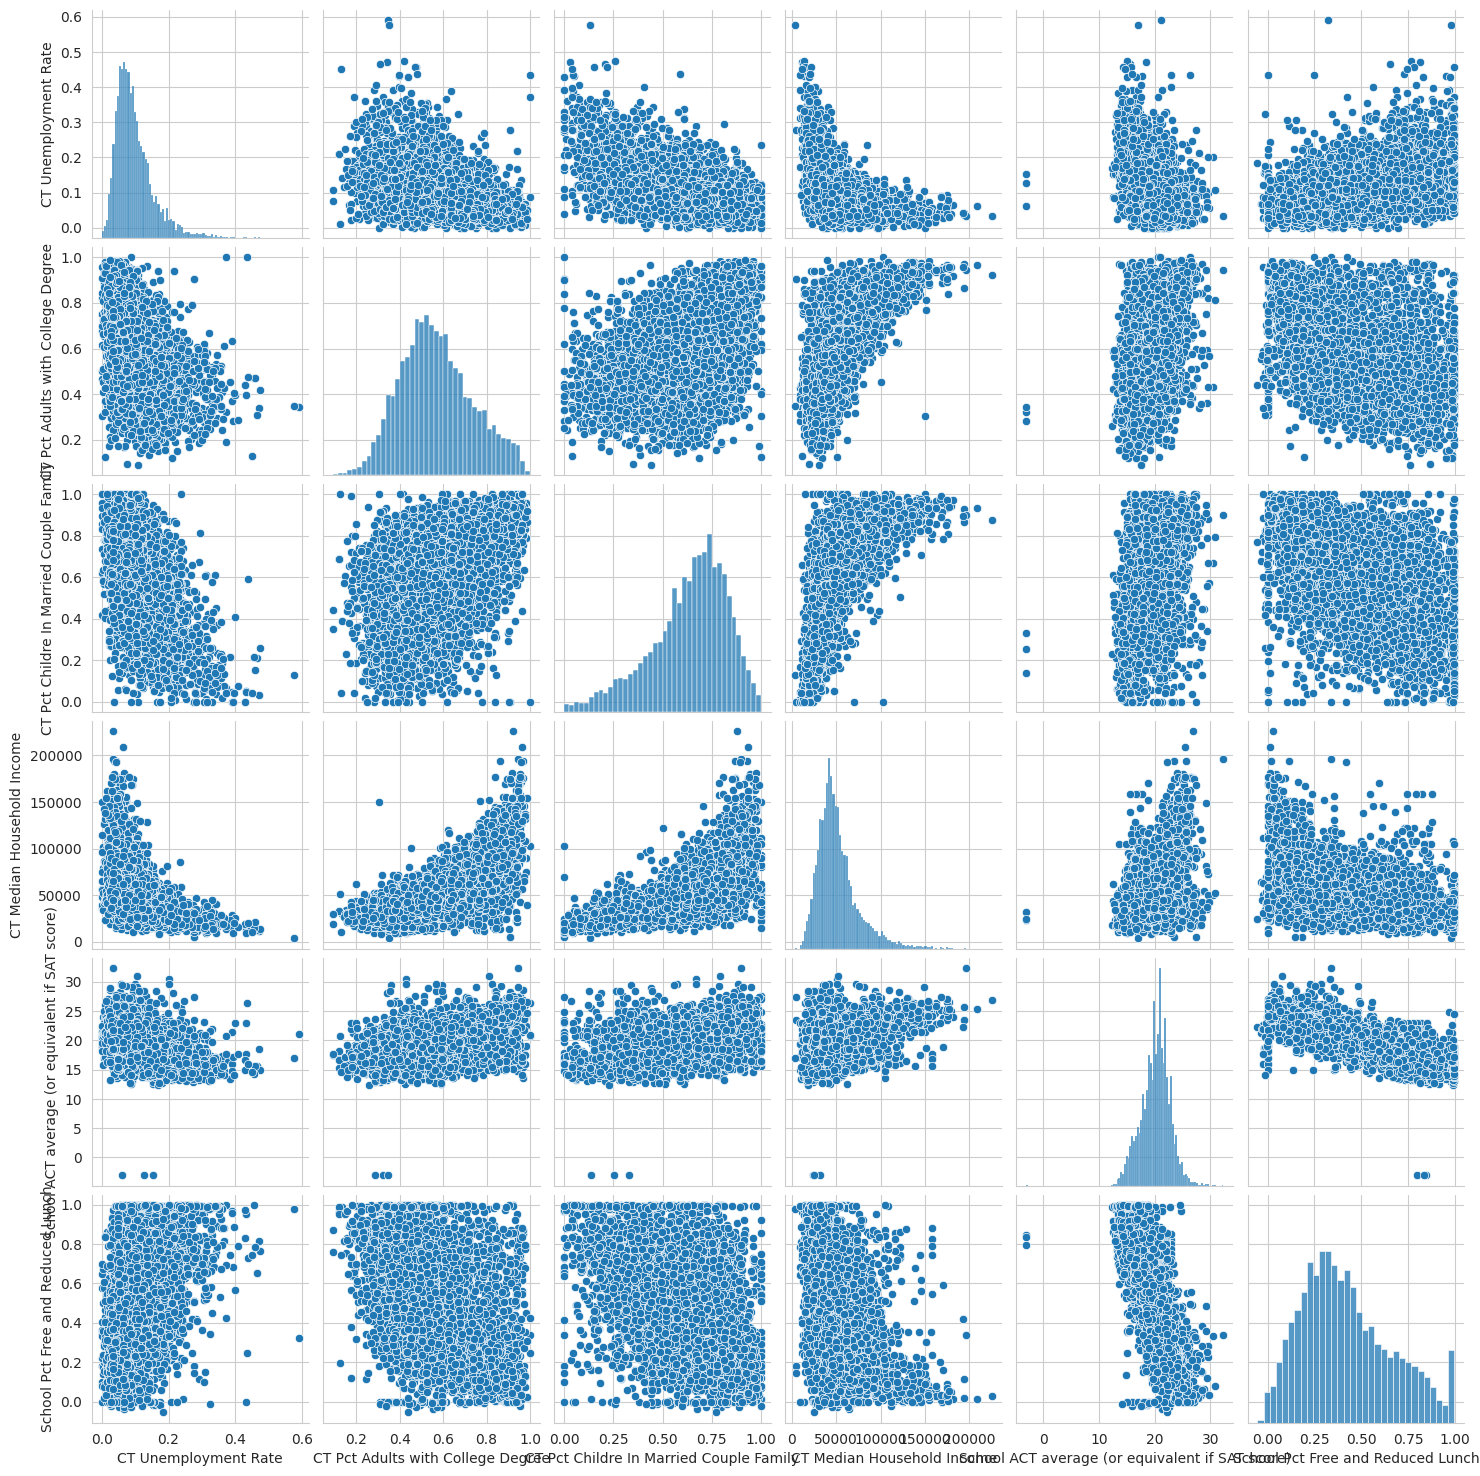

In [15]:
sns.pairplot(
    edgap.drop(columns="NCESSCH School ID")
);
plt.show()

The data shows that socioeconomic indicators such as median household income and college degrees correlate positively with ACT test scores and negatively with unemployment and Free/Reduced Lunch.

### Add regression lines and format the pair plot

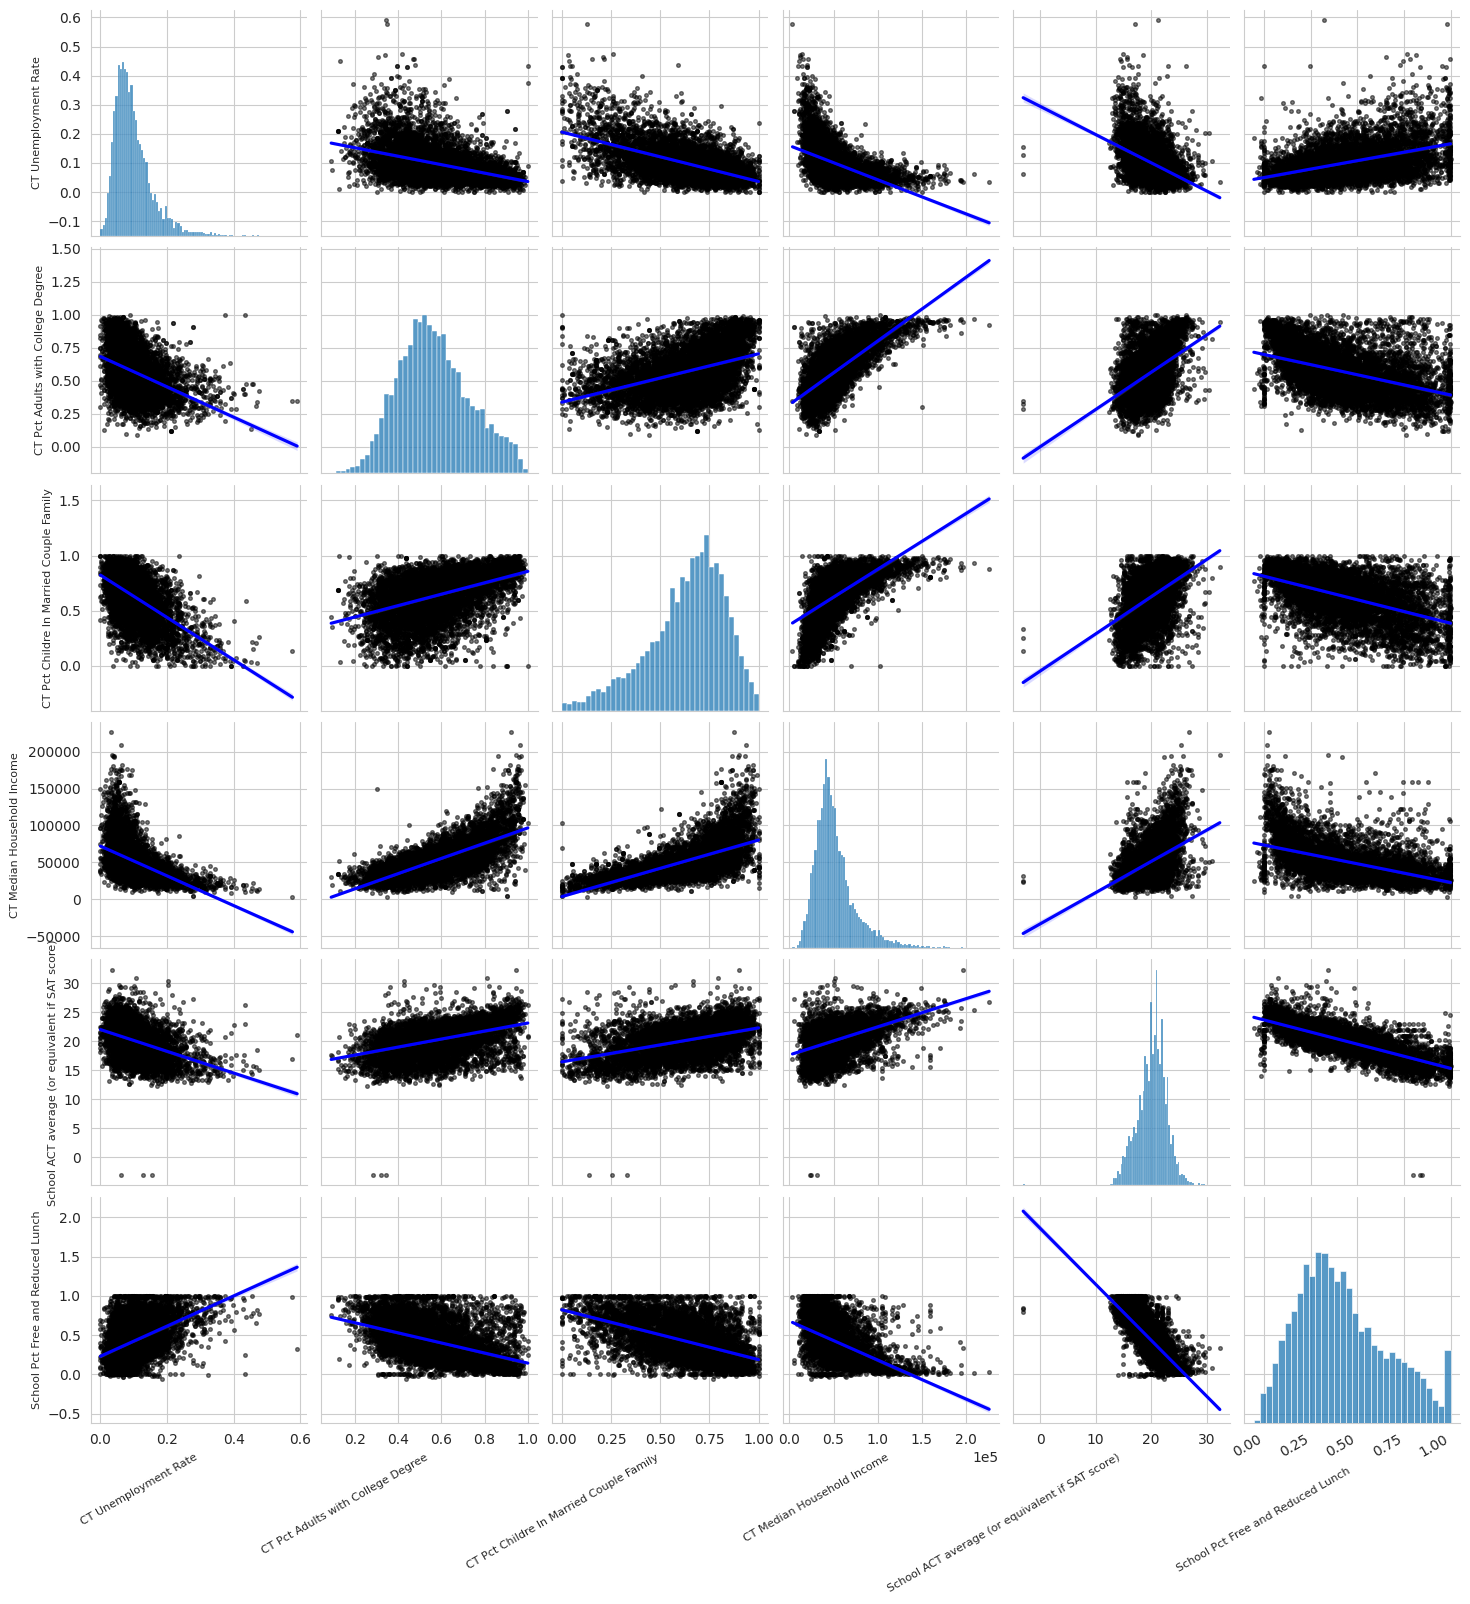

In [16]:
fig=sns.pairplot(
    edgap.drop(columns="NCESSCH School ID"),
    kind="reg",
    plot_kws={
    "line_kws":{'color':'blue'},
    "scatter_kws": {"alpha" : 0.5, "color" : "k" , "s":7},
    }

)
for ax in fig.axes.flat:
   if ax.get_xlabel() == "CT Median Household Income":
     ax.ticklabel_format(style='sci', axis='x' , scilimits=(0,0)) #Apply Scientific Notation
   ax.set_xlabel(ax.get_xlabel(), fontsize= 8, rotation=30, ha='right') #X-axis Label size and Rotation
   ax.set_ylabel(ax.get_ylabel(), fontsize= 8) #Y-axis Label size

#Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()



## Summary




1.   There appears to be a relationship between socioeconomic variables and the ACT score.
2.   There are some out of range ACT and percent lunch values that will need to be dealt with.
1.   We should have confidence that it is worthwhile to spend time preparing the data for analysis.






# Data Preparation

##Select relevant subsets of the data and rename the columns

### School Information Data Set

The school information data set contains many columns. We only need the year, school identity, location and school type information

Keep the columns SCHOOL_YEAR, NCESSCH, LSTATE, LZIP, SCH_TYPE_TEXT, LEVEL, CHARTER_TEXT

In [17]:
school_information = school_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

### Student Teacher Ratio Data Set

In [18]:
ratio= ratio[
    ['State Name','State Abbr [State] Latest available year','Pupil/Teacher Ratio [State] 2023-24'  ]
]

## Rename Columns

We will rename the columns to follow best practices of style and being informative. We can do this before or after joining the data sets. We will do it before joining the data sets to make it obvious that the key has the same name in each data set (this is not required but it makes work more readible)

In [19]:
edgap= edgap.rename(
    columns = {
    "NCESSCH School ID" : "id",
    "CT Pct Adults with College Degree" : "percent_college",
    "CT Unemployment Rate" : "unemployment_rate",
    "CT Pct Childre In Married Couple Family" : "percent_married",
    "CT Median Household Income" : "median_income",
    "School ACT average (or equivalent if SAT score)" : "act_average",
    "School Pct Free and Reduced Lunch" : "percent_lunch",
    }
)

In [20]:
school_information=school_information.rename(
    columns = {
    "SCHOOL_YEAR" : "year",
    "NCESSCH" : "id",
    "LSTATE" : "state",
    "LZIP" : "zip_code",
    "SCH_TYPE_TEXT" : "school_type",
    "LEVEL" : "school_level",
    "CHARTER_TEXT" : "charter"
    }
)

In [21]:
ratio= ratio.rename(
  columns={
  "State Abbr [State] Latest available year" : "state",
  "Pupil/Teacher Ratio [State] 2023-24" : "pupil_teacher_ratio"
  }
)


Lets now look at first few columns of the data set to make sure that the columns have been renamed in all the data sets.

In [22]:
edgap.head()

id  unemployment_rate  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  act_average  percent_lunch  
0        42820.0    20.433455       0.066901  
1        89320.0    19.498168       0.112412  
2        84140.0    19.554335       0.096816  
3        56500.0    17.737485       0.296960  
4        54015.0    18.245421       0.262641

In [23]:
school_information.head()

year            id state zip_code         school_type school_level  \
0  2016-2017  1.000020e+10    AL    35220  Alternative School         High   
1  2016-2017  1.000020e+10    AL    36067  Alternative School         High   
2  2016-2017  1.000020e+10    AL    36784  Alternative School         High   
3  2016-2017  1.000020e+10    AL    36057  Alternative School         High   
4  2016-2017  1.000020e+10    AL    35206  Alternative School         High   

  charter  
0      No  
1      No  
2      No  
3      No  
4      No

In [24]:
ratio.head()

State Name state pupil_teacher_ratio
0         ALABAMA   AL                17.47
1          ALASKA   AK                18.17
2  AMERICAN SAMOA   AS                    –
3         ARIZONA   AZ                22.69
4        ARKANSAS   AR                12.51

## Summary



1.   We selected a subset of columns of the school information data set and Student-Teacher Ratio  Data Set.

2.   We renamed the columns for clarity and to follow formatting guidelines.

1.   We are ready to join the data frames





## Join the Data Frames

We want to join the data frames using the identity of the school as the key. The identity is given by NCESSCH school identity. The value is an object in Edgap data set and float in the school information data set.

We will cast the id column in the school_information DataFrame as an object.

In [25]:
school_information['id'] = school_information['id'].astype('object')

In [26]:
school_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          102183 non-null  object
 1   id            102181 non-null  object
 2   state         102183 non-null  object
 3   zip_code      102183 non-null  object
 4   school_type   102181 non-null  object
 5   school_level  102179 non-null  object
 6   charter       102179 non-null  object
dtypes: object(7)
memory usage: 5.5+ MB


 Join both the data frames and combine them as df

In [27]:
df = edgap.merge(
    school_information,
    how ='left',
    on='id'
)

Lets look at the first few columns of the combined data set to make sure that the join has been performed as required.

In [28]:
df.head()

id  unemployment_rate  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  act_average  percent_lunch       year state zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE    19804   
1        89320.0    19.498168       0.112412  2016-2017    DE    19709   
2        84140.0    19.554335       0.096816  2016-2017    DE    19709   
3        56500.0    17.737485       0.296960  2016-2017    DE    19958   
4        54015.0    18.245421       0.262641  2016-2017    DE    19934   

      school_type school_level charter  
0  Regular School         High     Yes  
1  Regular School         High      No  
2  Regular School         High      No  
3  Regular School         High      No  
4  Regular School         High      No

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   object 
 1   unemployment_rate  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   act_average        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
 7   year               7898 non-null   object 
 8   state              7898 non-null   object 
 9   zip_code           7898 non-null   object 
 10  school_type        7898 non-null   object 
 11  school_level       7898 non-null   object 
 12  charter            7898 non-null   object 
dtypes: float64(6), object(7)
memory usage: 811.2+ KB




1. We joined the data sets using the school id as the key.
1. We first cast the id as an object in school infomation data set to have the same data type for the key in each data set.
2. We used a left join to keep all the Edgap Data.





# Quality Control

There are natural bounds for the numerical variables in the data set. Lets check the states we have data from and check the minimum and maximum values in each column.

We can use the describe() method to compute descriptive statistics

### What states do we have data from?

 Plot the results on map for the states we have data from for the combined data set.

In [30]:
import plotly.offline as po
import plotly.graph_objs as pg

In [31]:
layout=dict(
    geo={"scope":"usa"} , coloraxis_colorbar=dict(title="Number of Schools")
)

data=dict(
    type="choropleth",
    locations=df["state"].value_counts().index,
    locationmode="USA-states",
    z=df["state"].value_counts().values,
    coloraxis="coloraxis",
)

x=pg.Figure(data=[data], layout=layout)

po.iplot(x)

We are missing a large amount of USA data due to omission. This is not evident by examining Nan values in the data set.

We could obtain this information from public records, but we will not do that here.

### Lets see the number of states in Ratio Data Set first.

In [124]:
layout=dict(
    geo={"scope":"usa"} , coloraxis_colorbar=dict(title="Number of Schools")
)

data=dict(
    type="choropleth",
    locations=ratio["state"].value_counts().index,
    locationmode="USA-states",
    z=ratio["state"].value_counts().values,
    coloraxis="coloraxis",
)

x=pg.Figure(data=[data], layout=layout)

po.iplot(x)

In [33]:
ratio['state'].value_counts()

state
AL     1
AK     1
AS     1
AZ     1
AR     1
BI     1
CA     1
CO     1
CT     1
DE     1
DC     1
FL     1
GA     1
GU     1
HI     1
ID     1
IL     1
IN     1
IA     1
KS     1
KY     1
LA     1
ME     1
MD     1
MA     1
MI     1
MN     1
MS     1
MO     1
MT     1
NE     1
NV     1
NH     1
NJ     1
NM     1
NY     1
NC     1
ND     1
MP     1
OH     1
OK     1
OR     1
PA     1
PR     1
RI     1
SC     1
SD     1
TN     1
TX     1
VI     1
UT     1
VT     1
VA     1
WA     1
WV     1
WI     1
WY     1
Name: count, dtype: int64

We have more states in Student-Teacher Ratio Data set, so we will only keep the states we have in our merged data set of Edgap and School Information.

Lets check the data type of state first.

In [34]:

print(ratio['state'].dtype)


object


Lets convert it into a regular Python list.

In [35]:
print(ratio.columns.tolist())

['State Name', 'state', 'pupil_teacher_ratio']


Lets remove the whitespaces if there are in the data in column state

In [36]:
ratio.columns = ratio.columns.str.strip()

We will now filter the data for only 20 states we have in our data.

In [37]:
ratio['state'] = ratio['state'].astype(str)

# Strip whitespace and uppercase
ratio['state'] = ratio['state'].str.strip().str.upper()

# Now filter
selected_states = ['TX', 'OH', 'IL', 'PA', 'MI', 'NC', 'FL', 'GA', 'WI',
                   'NJ', 'MO', 'IN', 'NY', 'TN', 'WA', 'MA', 'KY', 'LA', 'WY', 'DE']

ratio_filtered = ratio.loc[ratio['state'].isin(selected_states)]
print(ratio_filtered)

        State Name state pupil_teacher_ratio
9         DELAWARE    DE               14.31
11         FLORIDA    FL               18.44
12         GEORGIA    GA               14.15
16        ILLINOIS    IL               13.53
17         INDIANA    IN               15.33
20        KENTUCKY    KY                15.3
21       LOUISIANA    LA               14.49
24   MASSACHUSETTS    MA               11.79
25        MICHIGAN    MI               16.58
28        MISSOURI    MO               12.77
33      NEW JERSEY    NJ                11.8
35        NEW YORK    NY               11.65
36  NORTH CAROLINA    NC               15.29
39            OHIO    OH               16.64
42    PENNSYLVANIA    PA               13.07
47       TENNESSEE    TN               15.13
48           TEXAS    TX               14.69
53      WASHINGTON    WA               17.49
55       WISCONSIN    WI               13.66
56         WYOMING    WY               12.22


We do not need the State Name column so we will remove that as well.

In [38]:
# Drop the column 'State Name'
ratio_filtered= ratio_filtered.drop(columns=['State Name'])

# Check the result
print(ratio_filtered.head())

   state pupil_teacher_ratio
9     DE               14.31
11    FL               18.44
12    GA               14.15
16    IL               13.53
17    IN               15.33


### Lets now join the Ratio Data Set as well

In [39]:
df = df.merge(ratio_filtered, on='state', how='left')

### Lets look at the combined data set again to make sure that the join has been performed as required.

In [40]:
df.head()

id  unemployment_rate  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  act_average  percent_lunch       year state zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE    19804   
1        89320.0    19.498168       0.112412  2016-2017    DE    19709   
2        84140.0    19.554335       0.096816  2016-2017    DE    19709   
3        56500.0    17.737485       0.296960  2016-2017    DE    19958   
4        54015.0    18.245421       0.262641  2016-2017    DE    19934   

      school_type school_level charter pupil_teacher_ratio  
0  Regular School         High     Yes               14.31  
1  Regular School         High      No               14.31  
2  Regular School         High      No               14.31  
3  Regular School         High      No               14.31  
4  Regular School         High      No               14.31

### Set out of range values to Nan using np.nan

The negative values in percent lunch has been set to Nan.

In [41]:
df.loc[df['percent_lunch']<0, 'percent_lunch'] = np.nan


The average act score values less than 1 are treated as invalid and replaced with Nan.

In [42]:
df.loc[df['act_average'] < 1, 'act_average'] = np.nan

### Check the types, levels and charter status of schools

In [43]:
df['school_type'].value_counts()

school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

In [44]:
df['school_level'].value_counts()

school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

In [45]:
df['charter'].value_counts()

charter
No                7329
Yes                352
Not applicable     217
Name: count, dtype: int64

### Keep only the High Schools as we do not need the elementary and other schools to look at ACT scores.

In [46]:
df= df.loc[df['school_level']== 'High']

### Check for duplicated rows

In [47]:
df.duplicated().sum()

np.int64(0)

### Identify missing values

In [48]:
df.isna().sum().to_frame(name='Number of missing value')

Number of missing value
id                                         0
unemployment_rate                         12
percent_college                           11
percent_married                           20
median_income                             16
act_average                                3
percent_lunch                             20
year                                       0
state                                      0
zip_code                                   0
school_type                                0
school_level                               0
charter                                    0
pupil_teacher_ratio                        0

### What percentage of values of each variable are missing

In [49]:
percent_missing = df.isna().mean().round(4)*100
percent_missing.to_frame(name='Percent Missing Values')

Percent Missing Values
id                                     0.00
unemployment_rate                      0.17
percent_college                        0.15
percent_married                        0.28
median_income                          0.22
act_average                            0.04
percent_lunch                          0.28
year                                   0.00
state                                  0.00
zip_code                               0.00
school_type                            0.00
school_level                           0.00
charter                                0.00
pupil_teacher_ratio                    0.00

## Drop the rows where ACT score is missing

In [50]:
df=df.dropna(subset="act_average")

In [51]:
df.isna().sum().to_frame(name='Number of missing value')

Number of missing value
id                                         0
unemployment_rate                         12
percent_college                           11
percent_married                           20
median_income                             16
act_average                                0
percent_lunch                             20
year                                       0
state                                      0
zip_code                                   0
school_type                                0
school_level                               0
charter                                    0
pupil_teacher_ratio                        0

If we drop the rows that have NaNs for any socioeconomic variables, then we will negatively affect our analysis using the variable where data were present. So, we will not drop the rows in this data set that are missing socioeconomic variables. We will impute the missing values.

## Summary



1.   We have only selected 20 states from Student-Teacher Ratio Data set and have cleaned up the data.
2.   The two columns were joined to the merged data set.
1.   We have set out of range values to Nan values and will impute them.
2.   We kept only high schools.
1.   We removed the schools where we do not have ACT scores.
1.   Many schools are missing from the data by omission.
2.   We will impute missing values for socioeconomic variables.
3.   We have added the student ratio data for the available 20 states.






# Data Imputation

### Define the predictor variables to be unemployment_rate, percent_college, percent_married, median_income, percent_lunch, state and charter.

In [52]:
predictor_variables=[
    'unemployment_rate',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter'
]

### Use the iterative imputer to replace missing values in the columns corresponding to predictor variables in the analysis.

In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [54]:
imputer= IterativeImputer()

## Fit the imputer using numerical predictor variables (this can include dummies for categorical variables).

Define the columns you want to use in the imputation process

In [55]:
numerical_predictors= df[predictor_variables].select_dtypes(include='number').columns.to_list()
print(numerical_predictors)

['unemployment_rate', 'percent_college', 'percent_married', 'median_income', 'percent_lunch']


Fit the imputer

In [56]:
  imputer.fit(df.loc[:, numerical_predictors])

IterativeImputer()

Impute the missing values in the training data

In [57]:
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

Check for missing values

In [58]:
df.isna().sum().to_frame(name='Number of missing value')

Number of missing value
id                                         0
unemployment_rate                          0
percent_college                            0
percent_married                            0
median_income                              0
act_average                                0
percent_lunch                              0
year                                       0
state                                      0
zip_code                                   0
school_type                                0
school_level                               0
charter                                    0
pupil_teacher_ratio                        0

## Export the clean Data Set

In [59]:
df.to_csv(
    'education_clean.csv',
     encoding='utf-8-sig',
     index=False
    )

In [60]:
from google.colab import files
files.download('education_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary


1.   We used an iterative imputer to estimate missing values of numerical predictor values
2.   We saved the clean data frame as a csv file.





# Exploratory Data Analysis

## Load the clean data

In [61]:
df=pd.read_csv('https://raw.githubusercontent.com/Kaurgurpreet23/Education/refs/heads/main/data/education_clean.csv')

## Examine distribution and relationships

Plot the correlation matrix of the numerical variables in the training data to explore relationships between the variables.

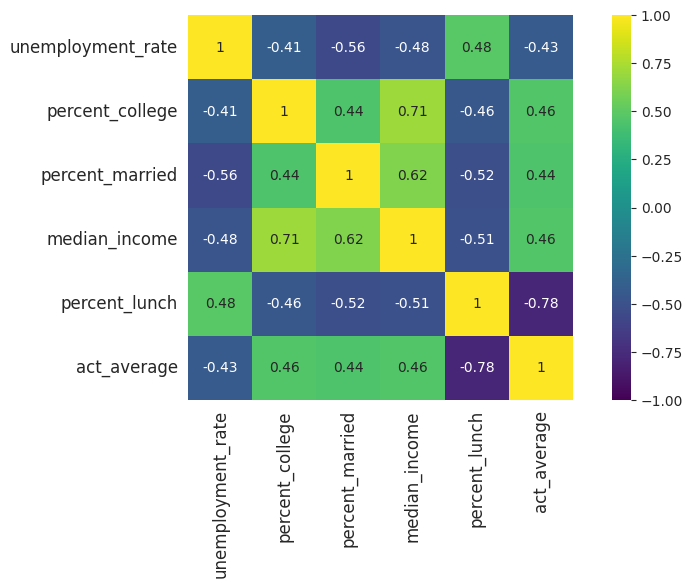

In [62]:
predictor_variables= ['unemployment_rate', 'percent_college', 'percent_married', 'median_income', 'percent_lunch','state','charter']

numerical_predictors= df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix=df[numerical_predictors+["act_average"]].corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis")

plt.tick_params(labelsize=12)

plt.show()

The above correlation matrix shows that ACT score has moderately strong relationship with other predictors and very strong relationships with percent lunch.

### Make pair plots to show relationships between the variables

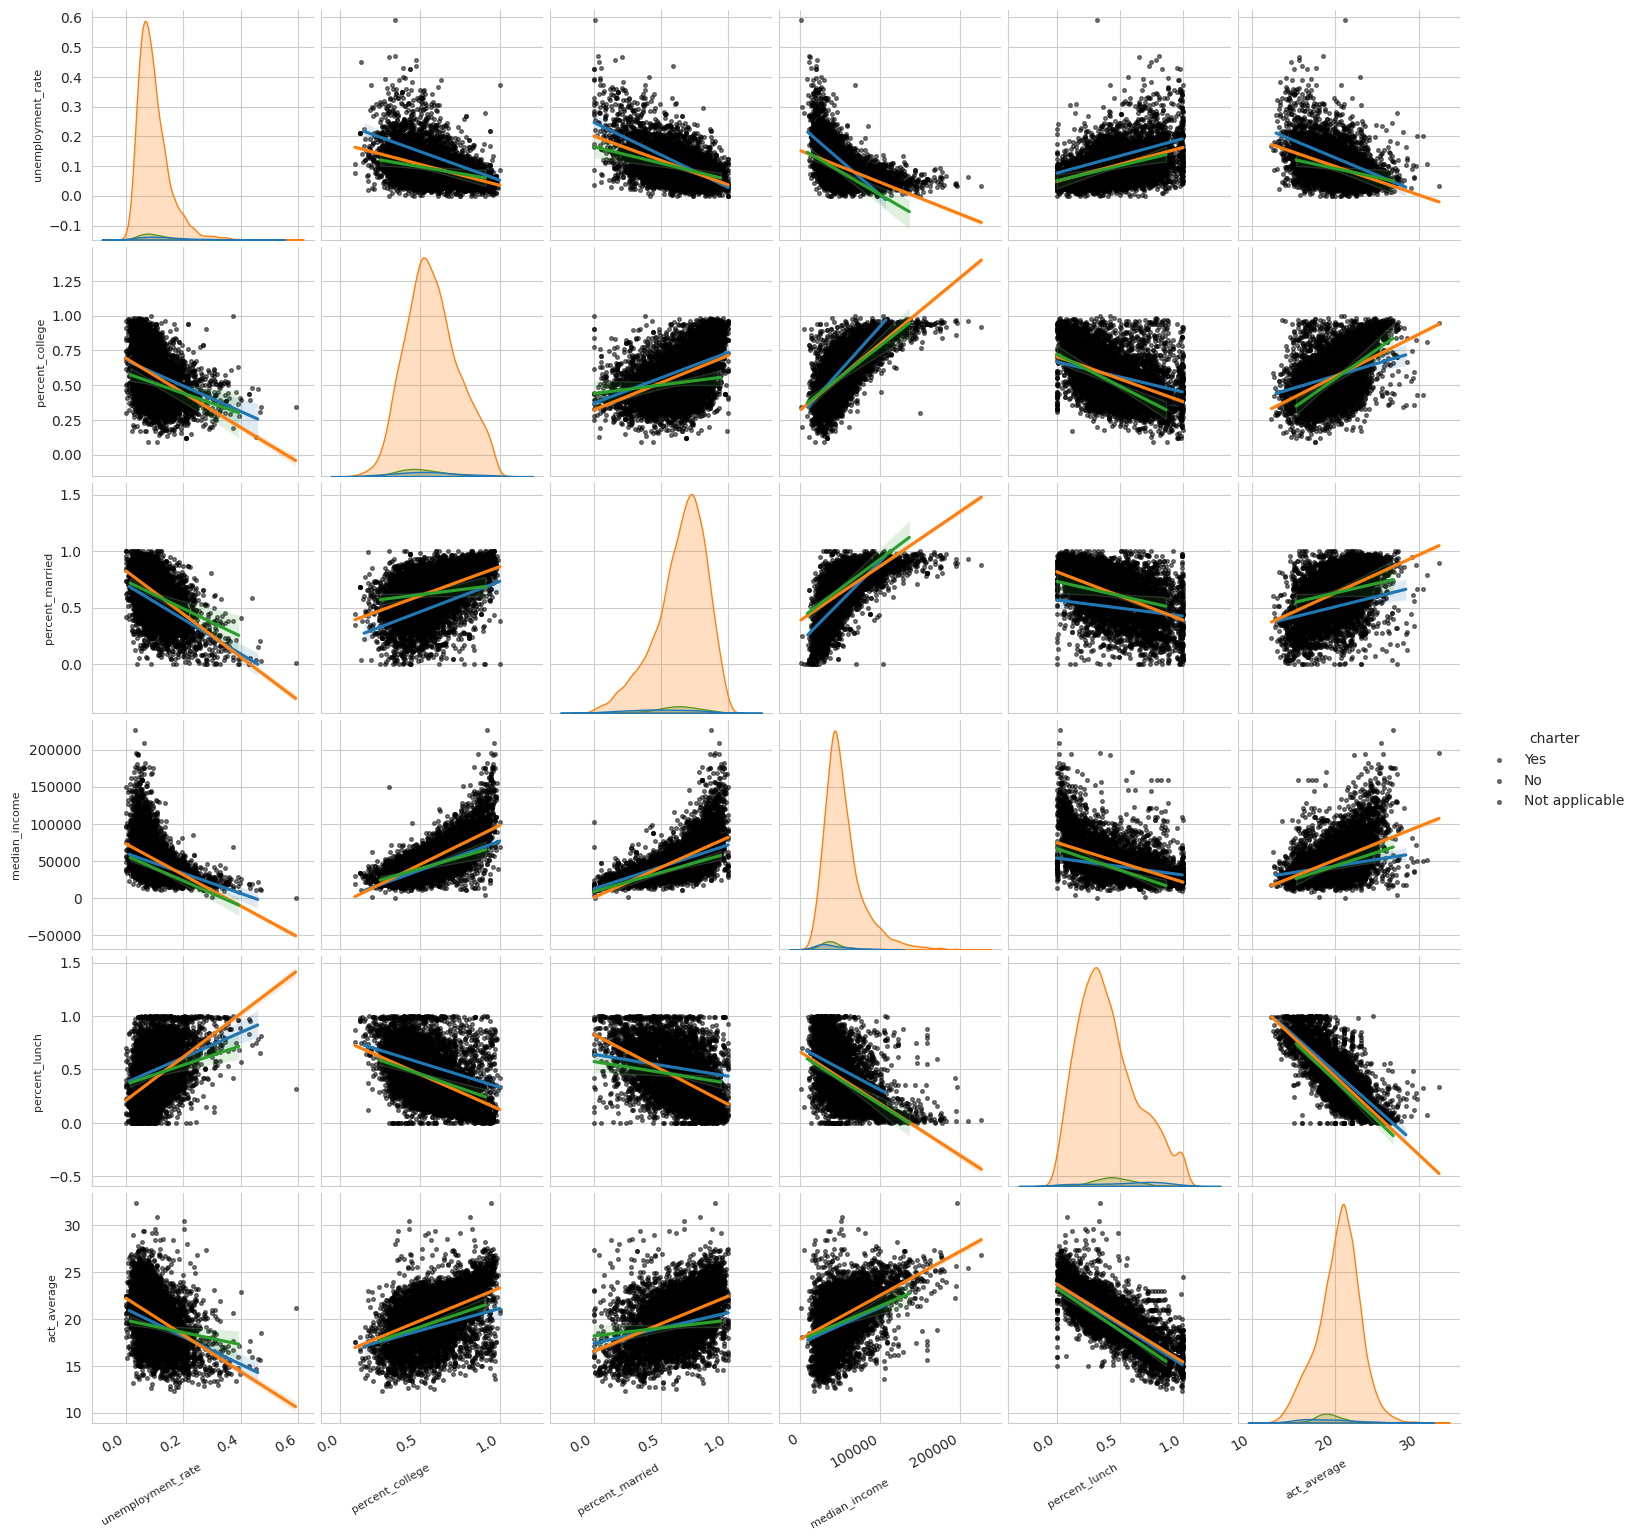

In [63]:
fig=sns.pairplot(
data=df,
vars= numerical_predictors + ["act_average"],
hue='charter',
kind="reg",
plot_kws = {"scatter_kws": {"alpha":0.5, "color":"k", "s":7},
},
)

for ax in fig.axes.flat:
  if ax.get_xlabel() == "CT Median Household Income":
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #Apply Scientific Notation
  ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right') #X-axis Label size and Rotation
  ax.set_ylabel(ax.get_ylabel(), fontsize=8) #Y-axis Label size

  #Rotate x-axis tick labels
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

The relationships are consistent across the plot, highlighting a positive connection between median income, percent college, and test scores

## Linear correlation between ACT scores and student–teacher ratio.

In [64]:
print(df[['act_average', 'pupil_teacher_ratio']].corr())

                     act_average  pupil_teacher_ratio
act_average             1.000000             0.028104
pupil_teacher_ratio     0.028104             1.000000


0.028 is very close to 0, which means there is almost no linear relationship between student–teacher ratio and average ACT score

### Make a pair plot to show relationship between act average and Student Teacher Ratio.

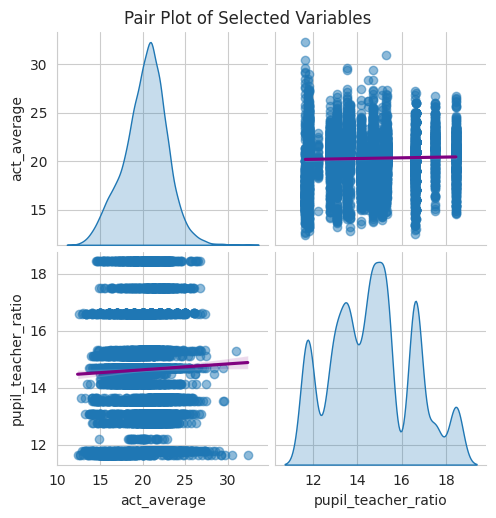

In [65]:
numeric_cols = ['act_average', 'pupil_teacher_ratio']

# Create the pair plot
sns.pairplot(df[numeric_cols], kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha':0.5}})

plt.suptitle('Pair Plot of Selected Variables', y=1.02)
plt.show()

The pair plot confirms the correlation result: pupil–teacher ratio alone does not explain ACT scores linearly, and most variation in ACT scores comes from other factors.

### Identify Outliers

We can use the interquartile range to identify outliers. This is also evident in the boxplots of the data. Median income is on a way different scale than the other predictors, so we will make two plots to explore the data.

Plot the data for all predictors except median income

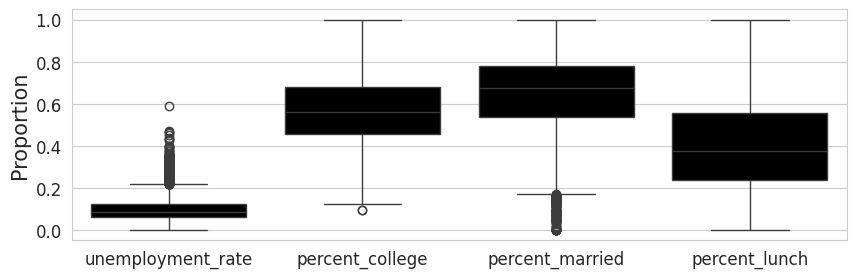

In [66]:
plt.figure(figsize=(10, 3))

fractions= list(numerical_predictors)
fractions.remove('median_income')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

The box plot displays the five-number summary of a set of data: the minimum, the first quartile, the median, the third quartile, and the maximum.
- The Box (Interquartile Range - IQR): The central box represents the middle 50% of the data, spanning from the Q1 (25th percentile) to theQ3 (75th percentile).
- The Line in the Box: This is the median Q2$ or 50th percentile.
- The Whiskers: The lines extending from the box show the range of the data (excluding outliers).
- Outliers (Dots): Individual points plotted outside the whiskers are considered outliers.




Plot the data for median income

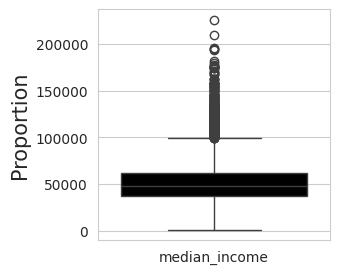

In [67]:
plt.figure(figsize=(3, 3))

sns.boxplot(data=df[['median_income']], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.show()

Plot the data for Student-Teacher Ratio

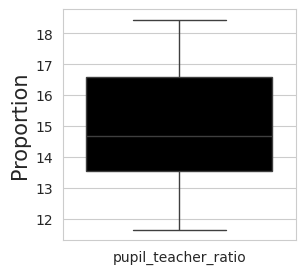

In [68]:
plt.figure(figsize=(3, 3))

sns.boxplot(data=df[['pupil_teacher_ratio']], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.show()

The box plot displays the pupil-teacher ratio distribution, with a median of about 16, an interquartile range of 15 to 17, and a range of 14 to 18, showing no extreme outliers.

## Summary

1.   The numerical predictors are related to act_average. The relationships appear roughly linear.
1.   The numerical predictors are correlated with each other, suggesting that not all predictors will be necessary.
1.   Some variables have skewed distributions, suggesting that transformation of input variables might be useful.
2.   There are outliers in unemployment_rate, percent_college, percent_married and median_income. None of these are obviously incorrect values; they likely reflect skewed distributions. We may consider applying something like a log transormation to these predictors as we explore different models.
2.   The relationships are similar across charter and non-charter schools but might be significantly different.




# Modeling

# Single Input Models

Fit and asses models predicting the average ACT score from each of the input variables. The polynomial linear regression models can be tried if found appropriate

## Median Income

### Plot the regression line and the scatter plot

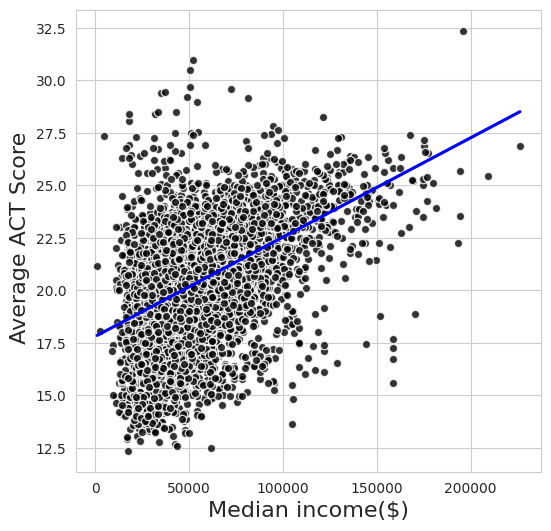

In [69]:
plt.figure(figsize=(6,6))

sns.regplot(
    data=df,
    x='median_income',
    y='act_average',
    color='blue',
    ci=False,
    scatter_kws={'color':'black', 'edgecolors':'white', 'linewidths':1}
)

#Add axis labels
plt.xlabel('Median income($)',fontsize=16)
plt.ylabel(' Average ACT Score',fontsize=16)

#Increase the fontsize of the tick labels

plt.show()


There is a relationship between the median income and the average ACT score. The scatter plot shows a positive correlation between median income ($) and average ACT score.However, the data points show quite a bit of variance meaning income is not the only factor influencing ACT scores — other factors likely play a role too.

### Fit the simple linear regression model.

 We want the average ACT to be the response variable and it is going to be predicted by a simple linear regression model where the median income is the predictor variable.

In [70]:
model_median_income = smf.ols(formula='act_average ~ median_income',data=df).fit()


We will display the fit summary

In [71]:
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1934.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:30   Log-Likelihood:                -16043.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.210e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8026      0.063    284.794

The above model indicates that the intercept in the model is 17.8 and that the coefficient on medican income is 4.7 times 10 to the negative 5. It is a very small coefficient because the median income is calculated in dollars and goes over a large range and the ACT score is over a much smaller range.  

### Numerical Assesment of fit accuracy

Compute the R-squared

In [72]:
model_median_income.rsquared

np.float64(0.21118648979301036)

Compute the Root mean Squared Error

In [73]:
y_hat=model_median_income.predict()

In [74]:
np.sqrt(mean_squared_error(df['act_average'], y_hat)).round(3)

np.float64(2.228)

Compute the mean absolute error

In [75]:
mean_absolute_error(df['act_average'], y_hat)

1.7129386980688535

The Mean absolute error is very small error in terms of th range of possible valuess for an ACT score. We are able to predict the ACT score from this particular input variable

### Residual plot for graphical assessment of model fit

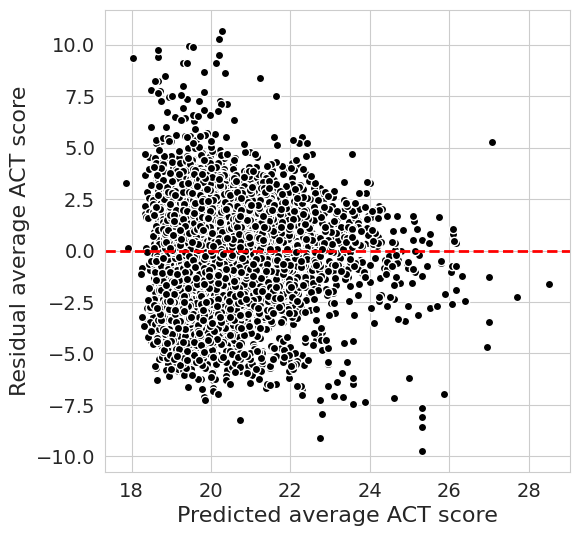

In [76]:
plt.figure(figsize=(6,6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()



We try to identify if there is a structure to this plot or only cloud of points without any structure. The above graph is not purely a cloud of points, so we will try a more complicated model

### Quadratic Polynomial Regression Model

Plot the regression curves and the scatter plot

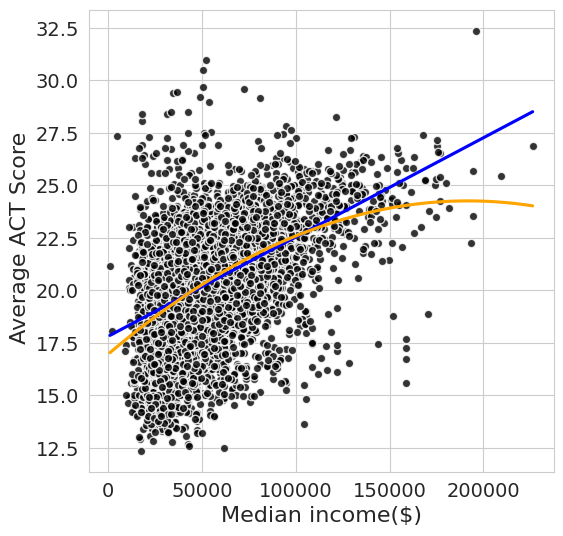

In [77]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
           x='median_income',
           y='act_average',
           color='blue',
           ci=False,
           scatter_kws={'color':'black', 'edgecolors':'white', 'linewidths':1})

sns.regplot(data=df,
            x='median_income',
            y='act_average',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

#Add axis labels
plt.xlabel('Median income($)',fontsize=16)
plt.ylabel(' Average ACT Score',fontsize=16)

#Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The two different graphs has been plotted, one with the simple linear regression model where the regression line has been plotted with blue and the quadratic regression line. The quadratic model might provide a slightly better fit but it is unclear that it is significantly better than the simple linear regression.

### Fit a quadratic linear regression model

In [78]:
model_median_income2= smf.ols(
    formula='act_average ~ median_income + I(median_income**2)',
    data=df
).fit()

We have added in squared version of median income

### Lets look at the fit summary again

In [79]:
print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1013.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:31   Log-Likelihood:                -16007.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.94

The above model show us the coefficinet on the squared term is statiscally significant.

We do have a significant quadratic term as well as significant linear term.

### Assess the model significance and an analysis of variance

In [80]:
model_median_income2.pvalues

Intercept                0.000000e+00
median_income            2.631899e-99
I(median_income ** 2)    1.395848e-17
dtype: float64

In [81]:
anova_lm(model_median_income, model_median_income2)

df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    7225.0  35865.012794      0.0         NaN        NaN           NaN
1    7224.0  35505.105960      1.0  359.906834  73.227974  1.395848e-17

### Compute the mean absolute error to compare the quadratic model accuracy to the first order model.

In [82]:
mean_absolute_error(df['act_average'], model_median_income2.predict())

1.6972389257619824

In [83]:
mean_absolute_error(df['act_average'], model_median_income.predict())

1.7129386980688535

This shows us that we have the ability to look at a relationshio between one of our socioeconomic factors and the average ACT score. A linear model is probably going to be sufficient to predict the ACT score as the value looks similar.

## Unemployment rate

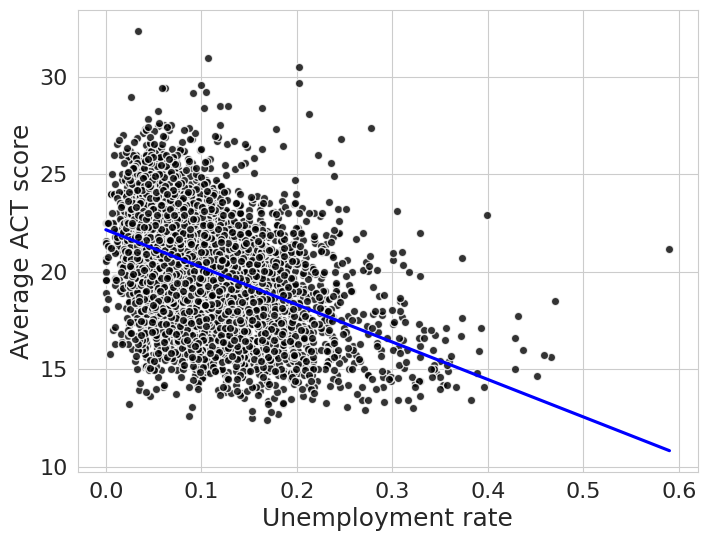

In [84]:
plt.figure(figsize=(8, 6))

sns.regplot(data=df,
            x='unemployment_rate',
            y='act_average',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
)

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16)

plt.show()

The regression line have a negative slope, demonstrating an inverse relationship: as the Unemployment Rate goes up Average ACT Score tends to go down.

 Lets display the fit summary

In [85]:
model_ru = smf.ols(formula='act_average ~ unemployment_rate', data=df).fit()

In [86]:
print(model_ru.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     1669.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:32   Log-Likelihood:                -16149.
No. Observations:                7227   AIC:                         3.230e+04
Df Residuals:                    7225   BIC:                         3.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1512      0.05

The model is significant, but it is not great. The $R^2 = 0.19$, which is low  suggests that the unemployment rate is a weak to moderate predictor of ACT Scores when used alone.

### Lets make a residual plot to assess the model.

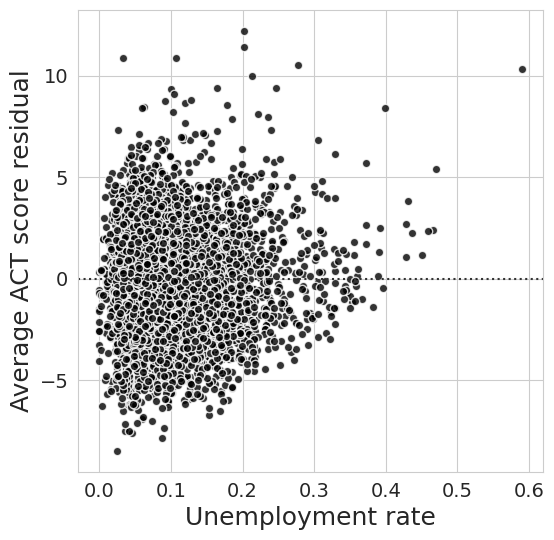

In [87]:
plt.figure(figsize=(6,6))

# residual plot
sns.residplot(data=df,
              x = 'unemployment_rate',
              y = 'act_average',
              scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score residual', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

Since the R-square is low, the model is statistically sound, but practically weak in its predictive power.

### Lets test whether a quadratic model is better.

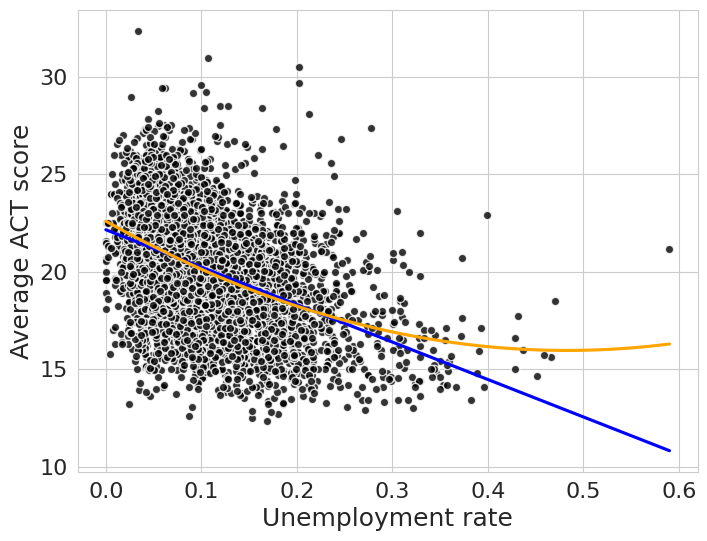

In [88]:
plt.figure(figsize=(8,6))

sns.regplot(x='unemployment_rate',
            y='act_average',
            color='blue',
            data=df,
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(x='unemployment_rate',
            y='act_average',
            color='orange',
            order = 2,
            data=df,
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16)

plt.show()

The purpose of this visualization is to use a visual diagnostic to determine if transforming the data might be necessary to improve the predictive power of the model, which we already identified as weak as R square is low, but structurally sound (based on the residual plot).

Lets do the fit summary

In [89]:
model_ru2 = smf.ols(formula='act_average ~ unemployment_rate + I(unemployment_rate**2)', data=df).fit()

In [90]:
print(model_ru2.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     865.0
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -16125.
No. Observations:                7227   AIC:                         3.226e+04
Df Residuals:                    7224   BIC:                         3.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

A quadratic model is significant, but it does not improve the fit by much.

In [91]:
anova_lm(model_ru, model_ru2)

df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    7225.0  36932.894308      0.0         NaN        NaN           NaN
1    7224.0  36682.406013      1.0  250.488295  49.329574  2.360918e-12

The chart visually confirms that the relationship between Unemployment Rate and ACT Scores is curved, or non-linear. Because the orange curve fits the data points better than the blue straight line, incorporating a curve into the model will make future predictions more accurate and should increase the model's predictive power.

## **Build a single input model for one of the other predictors**

## Percent of adults with a college degree

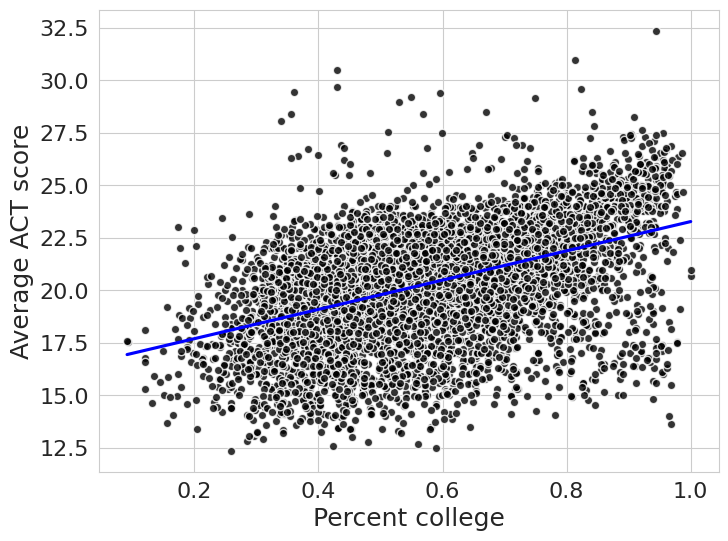

In [92]:
plt.figure(figsize=(8,6))

sns.regplot(data=df,
            x='percent_college',
            y='act_average',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent college', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16)

plt.show()

There is a moderate positive correlation between Percent College and Average ACT score. Areas or schools with a higher proportion of students planning to attend college generally have higher ACT scores.

Lets do the fit summary

In [93]:
model_pc = smf.ols(formula='act_average ~ percent_college', data=df).fit()

In [94]:
print(model_pc.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1922.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -16048.
No. Observations:                7227   AIC:                         3.210e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.3039      0.095    1

The model is significant, but it is not great. The $R^2 = 0.20$, which is low.

## Percent of adults married

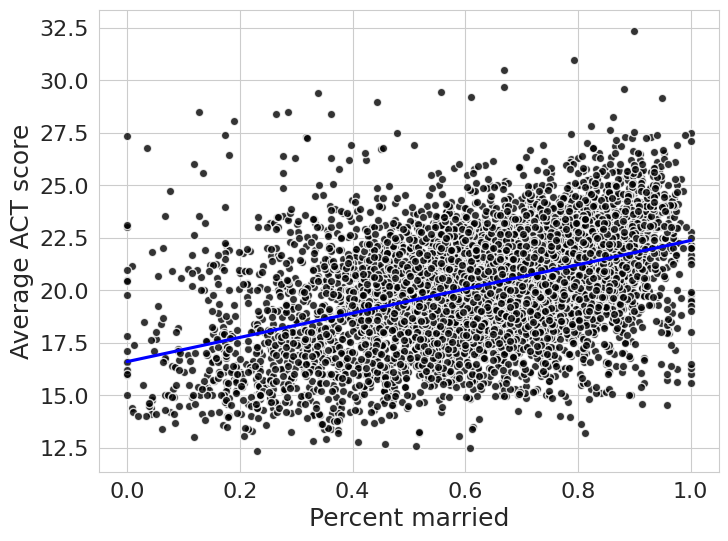

In [95]:
plt.figure(figsize=(8,6))


sns.regplot(data=df,
            x='percent_married',
            y='act_average',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent married', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

The upward slope of the trend line suggests that groups with higher marriage rates tend to have slightly higher average ACT scores, but the spread of the data points shows considerable variability.

Lets do fit summary

In [96]:
model_pm = smf.ols(formula='act_average ~ percent_married', data=df).fit()

In [97]:
print(model_pm.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1733.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:35   Log-Likelihood:                -16124.
No. Observations:                7227   AIC:                         3.225e+04
Df Residuals:                    7225   BIC:                         3.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.6046      0.093    1

Again, The model is significant, but it is not great. The  R-square=0.20 , which is low.

## Percent of students with free or reduced price lunch

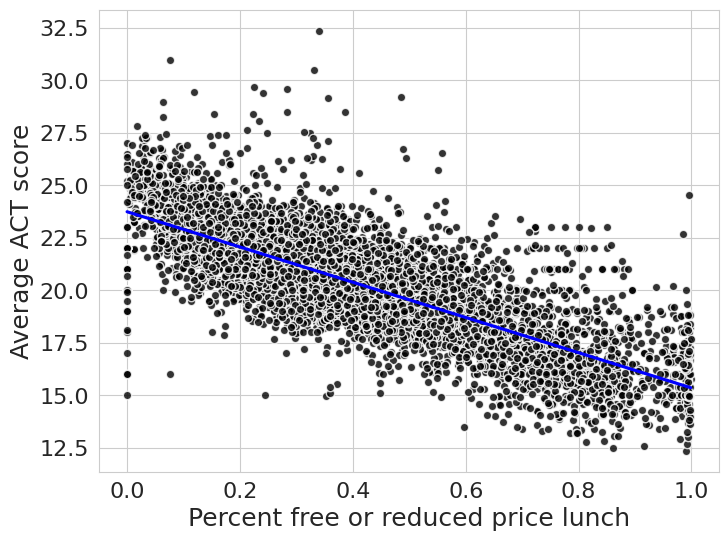

In [98]:
plt.figure(figsize=(8,6))

sns.regplot(data=df,
            x='percent_lunch',
            y='act_average',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent free or reduced price lunch', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

The downward slope of the trend line implies that groups with higher percentages of students receiving free or reduced-price lunch tend to have lower average ACT scores, though the variability in the data points indicates this relationship is not absolute.

Lets do fit summary

In [99]:
model_pl = smf.ols(formula='act_average ~ percent_lunch', data=df).fit()

print(model_pl.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.149e+04
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:36   Log-Likelihood:                -13461.
No. Observations:                7227   AIC:                         2.693e+04
Df Residuals:                    7225   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7429      0.037    641.745

There is a strong negative linear relationship between the percent of students with free or reduced price lunch and the average ACT score ($R^2 = 0.61$).

## Student Teacher Ratio

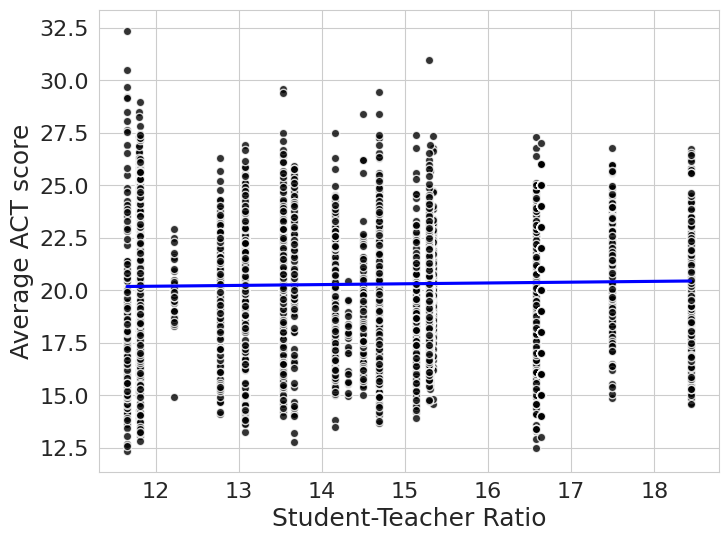

In [100]:
plt.figure(figsize=(8,6))

sns.regplot(data=df,
            x='pupil_teacher_ratio',
            y='act_average',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Student-Teacher Ratio', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

The scatter plot illustrates a negative trend where lower student-teacher ratios (12-18) are associated with higher average ACT scores (12.5-32.5), with an overall average ACT score of ~20, showing high variability.

Lets do fit summary

In [101]:
model_pl = smf.ols(formula='act_average ~ pupil_teacher_ratio', data=df).fit()

print(model_pl.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.711
Date:                Thu, 23 Oct 2025   Prob (F-statistic):             0.0169
Time:                        00:06:36   Log-Likelihood:                -16898.
No. Observations:                7227   AIC:                         3.380e+04
Df Residuals:                    7225   BIC:                         3.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              19.7347    

Despite statistical significance, the practical effect is negligible.The student-teacher ratio explains almost none of the variation in ACT scores.

### Lets make a residual plot to assess the model.

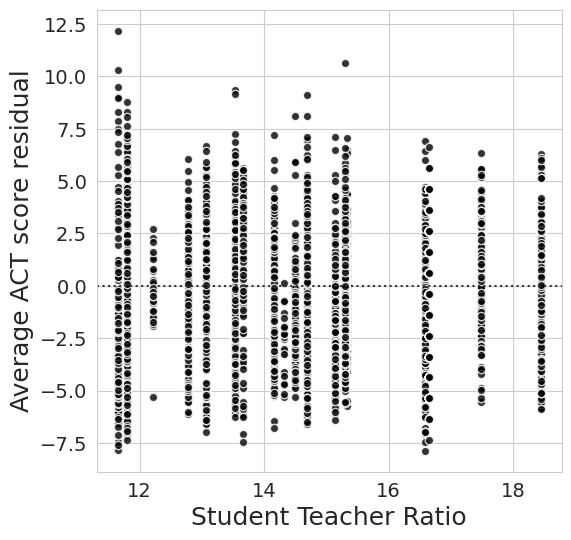

In [102]:
plt.figure(figsize=(6,6))

# residual plot
sns.residplot(data=df,
              x = 'pupil_teacher_ratio',
              y = 'act_average',
              scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Student Teacher Ratio', fontsize = 18)
plt.ylabel('Average ACT score residual', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The Student–Teacher Ratio alone doesn’t show a strong predictive relationship with ACT scores (residuals are wide and evenly distributed).

### Quadratic Polynomial Regression Model

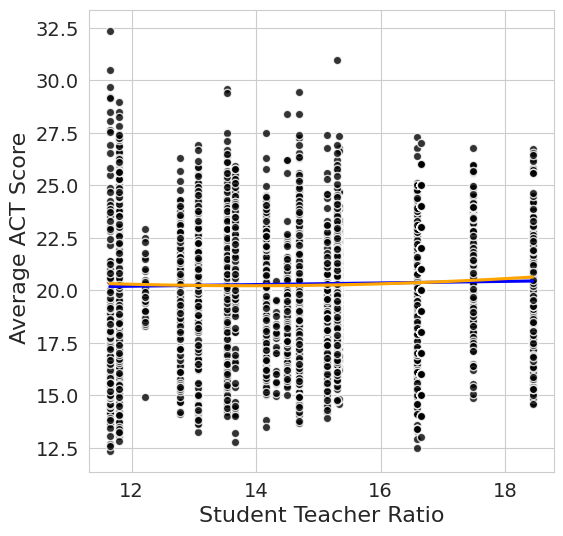

In [103]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
           x='pupil_teacher_ratio',
           y='act_average',
           color='blue',
           ci=False,
           scatter_kws={'color':'black', 'edgecolors':'white', 'linewidths':1})

sns.regplot(data=df,
            x='pupil_teacher_ratio',
            y='act_average',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

#Add axis labels
plt.xlabel('Student Teacher Ratio',fontsize=16)
plt.ylabel(' Average ACT Score',fontsize=16)

#Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

There is not much difference than the simple linear regression model.

#Multiple Linear Regression

## Multiple Linear Regression model using all socioeconomic variables as predictors.

Lets fit a multiple linear regression model that quantifies how socioeconomic factors collectively relate to the average ACT score.

In [104]:
model=smf.ols(
    formula='act_average ~ unemployment_rate + percent_college + percent_married + median_income + percent_lunch+pupil_teacher_ratio',
    data=df
).fit()

### Print Model Summary


In [105]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2043.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:38   Log-Likelihood:                -13315.
No. Observations:                7227   AIC:                         2.664e+04
Df Residuals:                    7220   BIC:                         2.669e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              21.9440    

The coefficients of percent married and median income has relatively large P values indicating that they are not statiscally significant. We have also noticed that the R sqaure is much higher than any of our individual predictor models.In other words, the model predicts ACT scores using 6 variables and explains ~63% of the variance

### Use a residual plot for graphical assessment of model fit

In [106]:
y_hat

array([19.82889475, 22.02932791, 21.78420439, ..., 19.92713344,
       22.16248961, 21.29722251])

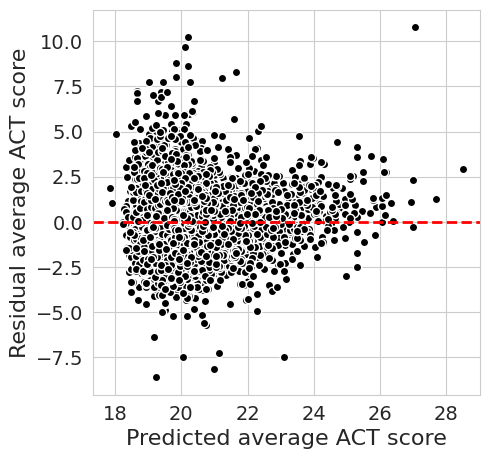

In [107]:
plt.figure(figsize=(5,5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is relatively no structure to the residual plot indicating that we are unlikely to improve the model by making transformations of the input variables that we have used in the model.

### Numerical Assessment

### Compute the mean absolute error

In [108]:
mean_absolute_error(df['act_average'], model.predict())

1.1419232694675383

This is less than what we have noticed in individual predictor model.

## Summary


1.   The multiple linear regression model with all socioeconomic predictors can predict ACT scores with an average error or roughly one point using these predictors
1.   The residual plot suggests that there will be limited improvement from adding transformations of these predictors.
2.   Not all predictors have significant coefficients.
2.   Adding predictors to the model may improve the performance.



# Reduced Model

Fit a reduced model with significant predators that has statiscally significant coefficients and check if the reduced model is sufficient to predict the average ACT score.

In [109]:
model_reduced=smf.ols(
    formula='act_average ~ unemployment_rate + percent_college + percent_lunch',
    data=df
).fit()


### Print Summary

In [110]:
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:38   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6400      0.10

## Use a residual plot for graphical assessment of model fit

In [111]:
y_hat=model_reduced.predict()

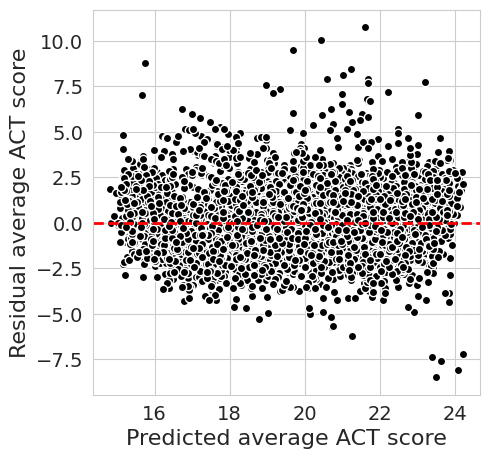

In [112]:
plt.figure(figsize=(5,5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is no structure to the model indicating that we do not need to include transformations of these particular predictors in order to improve the model.

## Numerical Assessment

### Compute the mean absolute error

In [113]:
mean_absolute_error(df['act_average'], model_reduced.predict())

1.1454832950346354

### Compare the accuracy between full and reduced models

In [114]:
mae_full=mean_absolute_error(df['act_average'], model.predict())
mae_reduced=mean_absolute_error(df['act_average'], model_reduced.predict())

r2_full=model.rsquared
r2_reduced=model_reduced.rsquared

pd.DataFrame({'Mean Abolute Error':[mae_full, mae_reduced],
              'R-squared':[r2_full, r2_reduced]},
             index=['full model', 'reduced model']).round(4)

Mean Abolute Error  R-squared
full model                 1.1419     0.6293
reduced model              1.1455     0.6279

### Consider the significance of the difference between the models using an ANOVA.

In [115]:
anova_lm(model, model_reduced)

df_resid           ssr  df_diff    ss_diff         F  Pr(>F)
0    7220.0  16854.687117      0.0        NaN       NaN     NaN
1    7223.0  16916.619167     -3.0 -61.932051  8.814511     NaN

There is no statiscally significant difference between the reduced model and the full model.

## Summary



*   The model predicting the average ACT score from unemployment_rate, percent_college and percent_lunch is not significantly different than the model with all socioeconomic variables as predictors.
*   Adding predictors to the model may improve the performance.
*   We have not yet determined the relative importance of each predictor in the model.



# Model with Standardized Predictors

## Scaling

We will define predictor variables

In [116]:
predictor_variables= ['unemployment_rate', 'percent_college', 'percent_lunch']

Adding Normalized to predictor variables to distinguish original variables and the normalized value

In [117]:
scaled_columns=[var + '_normalized' for var in predictor_variables]
print(scaled_columns)

['unemployment_rate_normalized', 'percent_college_normalized', 'percent_lunch_normalized']


Scaling the predictor variables in the reduced model to gave mean of zero and standard deviation of one and then add them to the data frame.

In [118]:
scaler= StandardScaler().fit(df[predictor_variables])

In [119]:
df[scaled_columns]=scaler.transform(df[predictor_variables])

Check the mean and standard deviation of the transformed data

In [120]:
df[scaled_columns].agg(['mean','std']).round(3)

unemployment_rate_normalized  percent_college_normalized  \
mean                          -0.0                        -0.0   
std                            1.0                         1.0   

      percent_lunch_normalized  
mean                       0.0  
std                        1.0

## Fit multiple linear regression model with those normalized predictors

In [121]:
model_normalized=smf.ols(
    formula='act_average ~ unemployment_rate_normalized + percent_college_normalized + percent_lunch_normalized',
    data=df
).fit()

Print Summary

In [122]:
print(model_normalized.summary())

                            OLS Regression Results                            
Dep. Variable:            act_average   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:06:39   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

We have much larger magnitude of a coefficient for percent_lunch variable comparing to the other two.

### Numerical Assessment

Compare the accuracy between the original and normalized models

In [123]:
mae_normalized=mean_absolute_error(df['act_average'], model_normalized.predict())
mae_reduced=mean_absolute_error(df['act_average'], model_reduced.predict())

r2_normalized=model_normalized.rsquared
r2_reduced=model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_normalized, mae_reduced],
              'R-squared': [r2_normalized, r2_reduced]},
             index=['normalized model', 'reduced model']).round(4)

Mean Absolute Error  R-squared
normalized model               1.1455     0.6279
reduced model                  1.1455     0.6279

The transformation from original predictors to their standardized versions does not lead to an overall change in the linear regression model. It is only changing the coefficients in the model. The coefficient of percent lunch has changed to much extent comparitive to the other two.

#Results


This report investigates the relationship between student–teacher ratios and student academic performance across 20 U.S. states. The goal is to understand whether states with smaller class sizes (lower student–teacher ratios) tend to perform better on standardized tests such as the ACT. This question matters for education policymakers and administrators who must allocate resources efficiently while improving student learning outcomes. By analyzing publicly available datasets, the project explores whether smaller classes correlate with stronger academic results.

In addition to this, I will examine the relationship between the average ACT score and the five socioeconomic predictor variables in the EdGap data set to check which socioeconomic predictor variable has closer relationship or effect on a student’s performance in the 20 states we have data from.


